In [73]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Scikit-learn for modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# Statsmodels for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# XGBoost for advanced modeling
import xgboost as xgb

In [74]:

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

# Mount Google Drive (if using Colab with Drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
# Load the dataset (assuming it's in your Drive)
# You'll need to adjust the path to match your file location
file_path = '/content/drive/MyDrive/walmart-sales-forecast/content/train.csv (1).zip'  # Update this path
store_path = '/content/drive/MyDrive/walmart-sales-forecast/content/stores (1).csv'  # Update this path
features_path = '/content/drive/MyDrive/walmart-sales-forecast/content/features (1).csv'  # Update this path


In [76]:
# Load the data
df = pd.read_csv('/content/train.csv (1).zip')
stores_df = pd.read_csv('/content/stores (1).csv')
features_df = pd.read_csv('/content/features (1).csv')

In [77]:
# Display basic information about the datasets
print("Sales Data Shape:", df.shape)
print("Stores Data Shape:", stores_df.shape)
print("Features Data Shape:", features_df.shape)

print("\nSales Data Columns:")
print(df.columns.tolist())

print("\nFirst few rows of sales data:")
df.head()

Sales Data Shape: (421570, 5)
Stores Data Shape: (45, 3)
Features Data Shape: (8190, 12)

Sales Data Columns:
['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

First few rows of sales data:


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Data Preprocessing

In [78]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [79]:
# Merge all datasets
# First merge sales with features
merged_df = pd.merge(df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

In [80]:
# Then merge with stores data
merged_df = pd.merge(merged_df, stores_df, on=['Store'], how='left')

In [81]:
# Check for missing values
print("Missing values in merged dataset:")
print(merged_df.isnull().sum())

Missing values in merged dataset:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64


In [82]:
# Handle missing values - fill with 0 or appropriate values
merged_df['MarkDown1'] = merged_df['MarkDown1'].fillna(0)
merged_df['MarkDown2'] = merged_df['MarkDown2'].fillna(0)
merged_df['MarkDown3'] = merged_df['MarkDown3'].fillna(0)
merged_df['MarkDown4'] = merged_df['MarkDown4'].fillna(0)
merged_df['MarkDown5'] = merged_df['MarkDown5'].fillna(0)
merged_df['CPI'] = merged_df['CPI'].fillna(merged_df['CPI'].mean())
merged_df['Unemployment'] = merged_df['Unemployment'].fillna(merged_df['Unemployment'].mean())

In [83]:
# Create additional date-based features
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Week'] = merged_df['Date'].dt.isocalendar().week
merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek
merged_df['DayOfYear'] = merged_df['Date'].dt.dayofyear

In [84]:
 #Check the final dataset
print("\nFinal merged dataset shape:", merged_df.shape)
print("\nFinal dataset info:")
merged_df.info()


Final merged dataset shape: (421570, 21)

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     421570 non-null  float64       
 8   MarkDown2     421570 non-null  float64       
 9   MarkDown3     421570 non-null  float64       
 10  MarkDown4     421570 non-null  float64       
 11  MarkDown5     421570 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type 

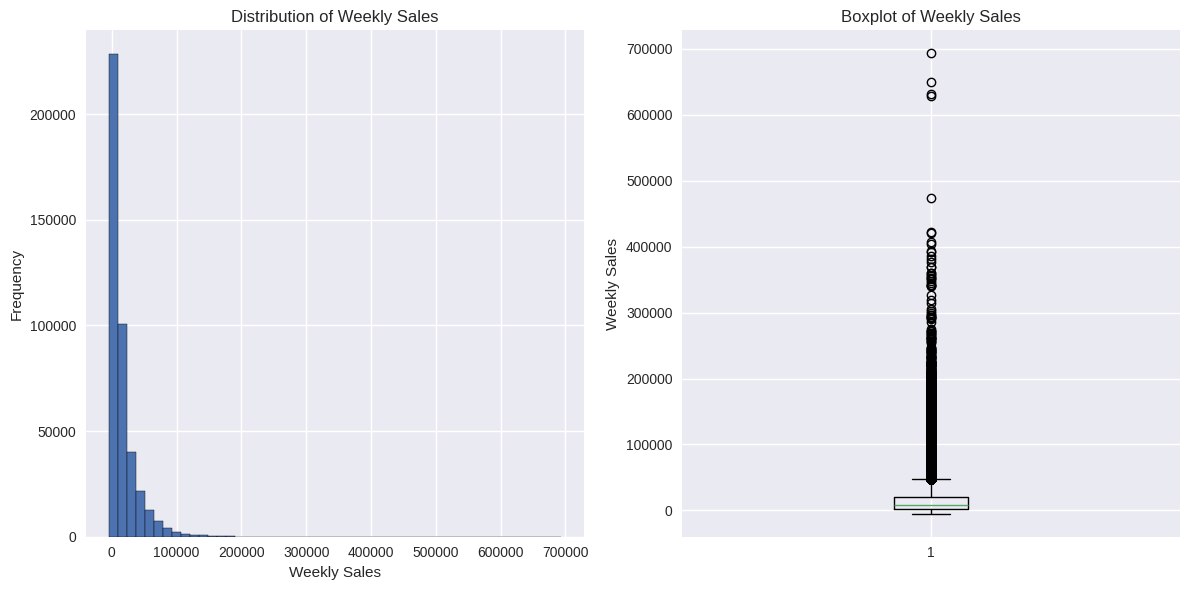

In [85]:
# Exploratory Data Analysis
# Sales distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(merged_df['Weekly_Sales'], bins=50, edgecolor='black')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(merged_df['Weekly_Sales'])
plt.title('Boxplot of Weekly Sales')
plt.ylabel('Weekly Sales')

plt.tight_layout()
plt.show()


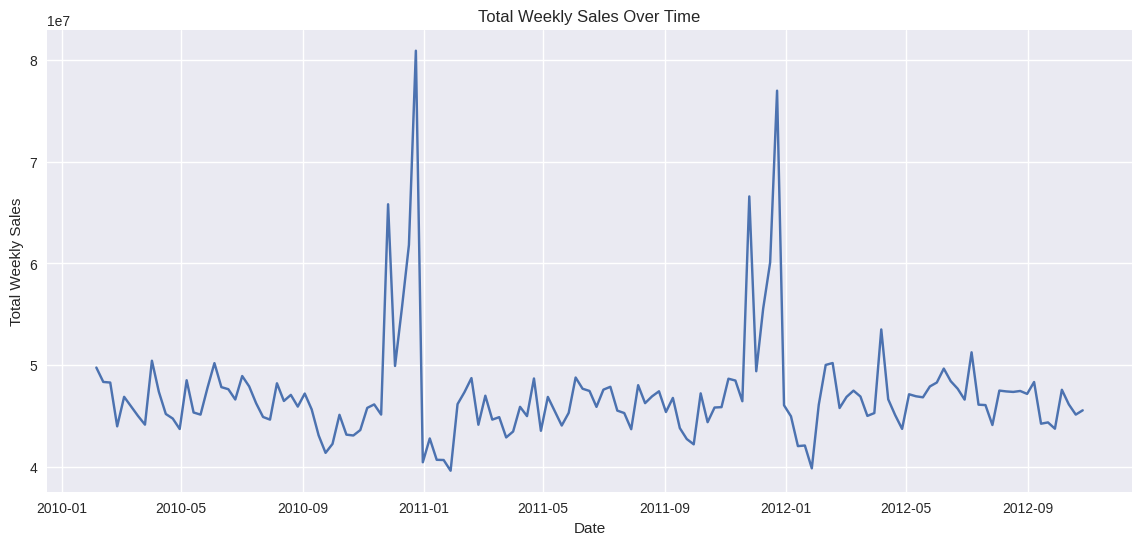

In [86]:
# Sales over time
plt.figure(figsize=(14, 6))
weekly_sales = merged_df.groupby('Date')['Weekly_Sales'].sum()
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.grid(True)
plt.show()

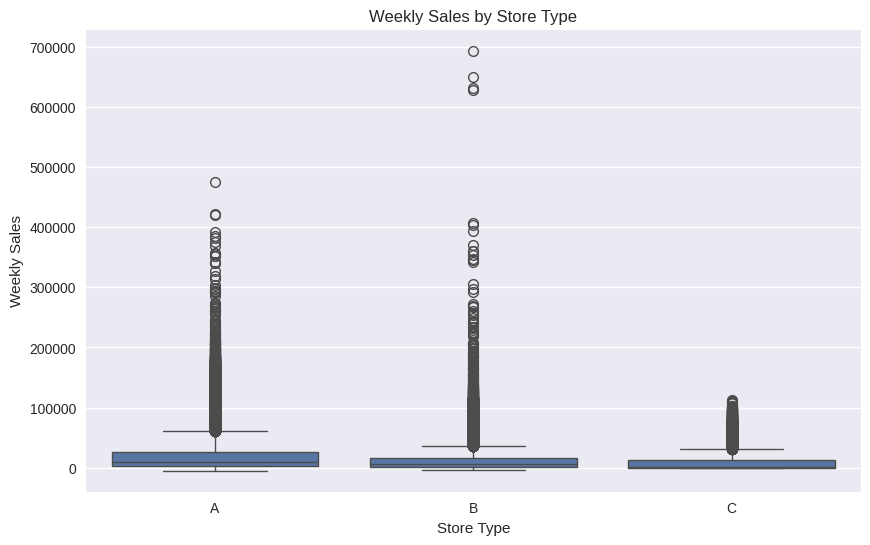

In [87]:
# Sales by store type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Weekly_Sales', data=merged_df)
plt.title('Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.show()

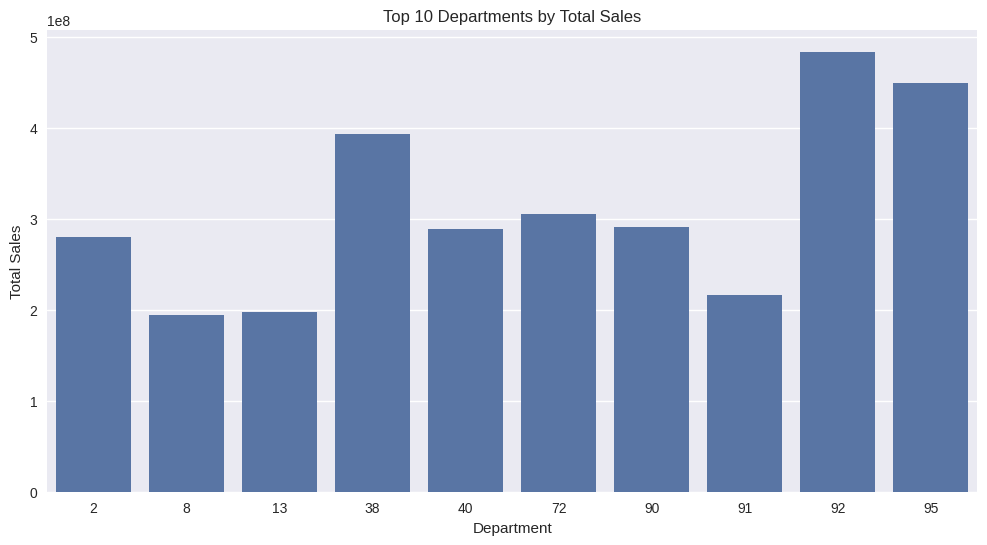

In [88]:
# Sales by department
top_depts = merged_df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_depts.index, y=top_depts.values)
plt.title('Top 10 Departments by Total Sales')
plt.xlabel('Department')
plt.ylabel('Total Sales')
plt.show()

Time Series Analysis and Feature Engineering

In [89]:
weekly_data = merged_df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
})

weekly_data = weekly_data.resample('W').agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
})

# Fill missing Weekly_Sales with 0, and other features with their mean
weekly_data['Weekly_Sales'] = weekly_data['Weekly_Sales'].fillna(0)
weekly_data['Temperature'] = weekly_data['Temperature'].fillna(weekly_data['Temperature'].mean())
weekly_data['Fuel_Price'] = weekly_data['Fuel_Price'].fillna(weekly_data['Fuel_Price'].mean())
weekly_data['CPI'] = weekly_data['CPI'].fillna(weekly_data['CPI'].mean())
weekly_data['Unemployment'] = weekly_data['Unemployment'].fillna(weekly_data['Unemployment'].mean())

# Check for stationarity
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(weekly_data['Weekly_Sales'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -5.908298e+00
p-value                        2.675979e-07
#Lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


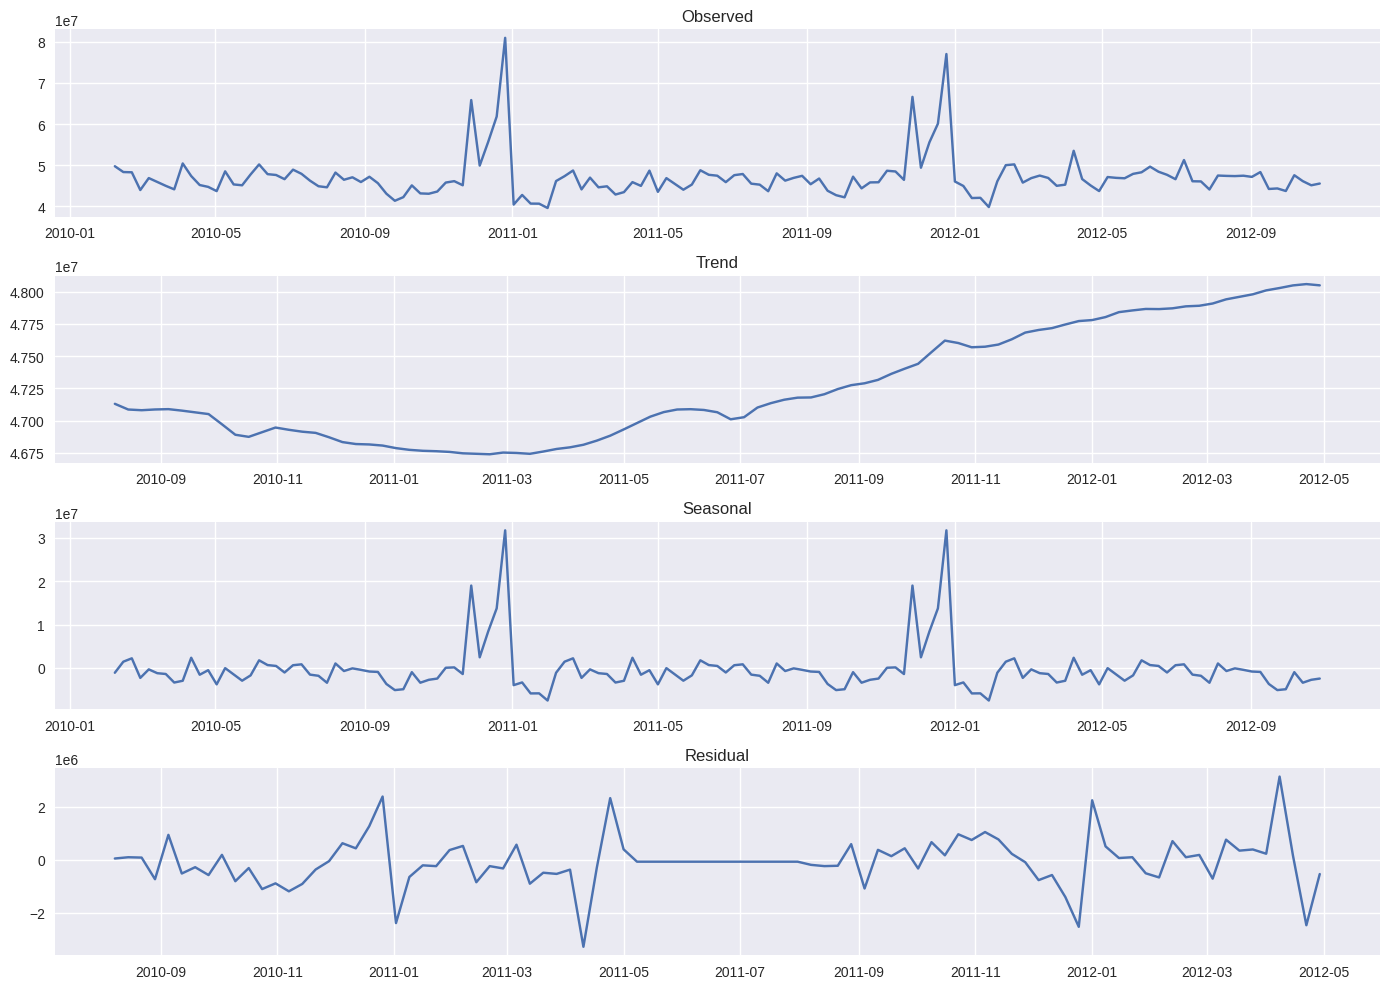

In [90]:
# Decompose the time series
decomposition = seasonal_decompose(weekly_data['Weekly_Sales'].dropna(), period=52)

plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()

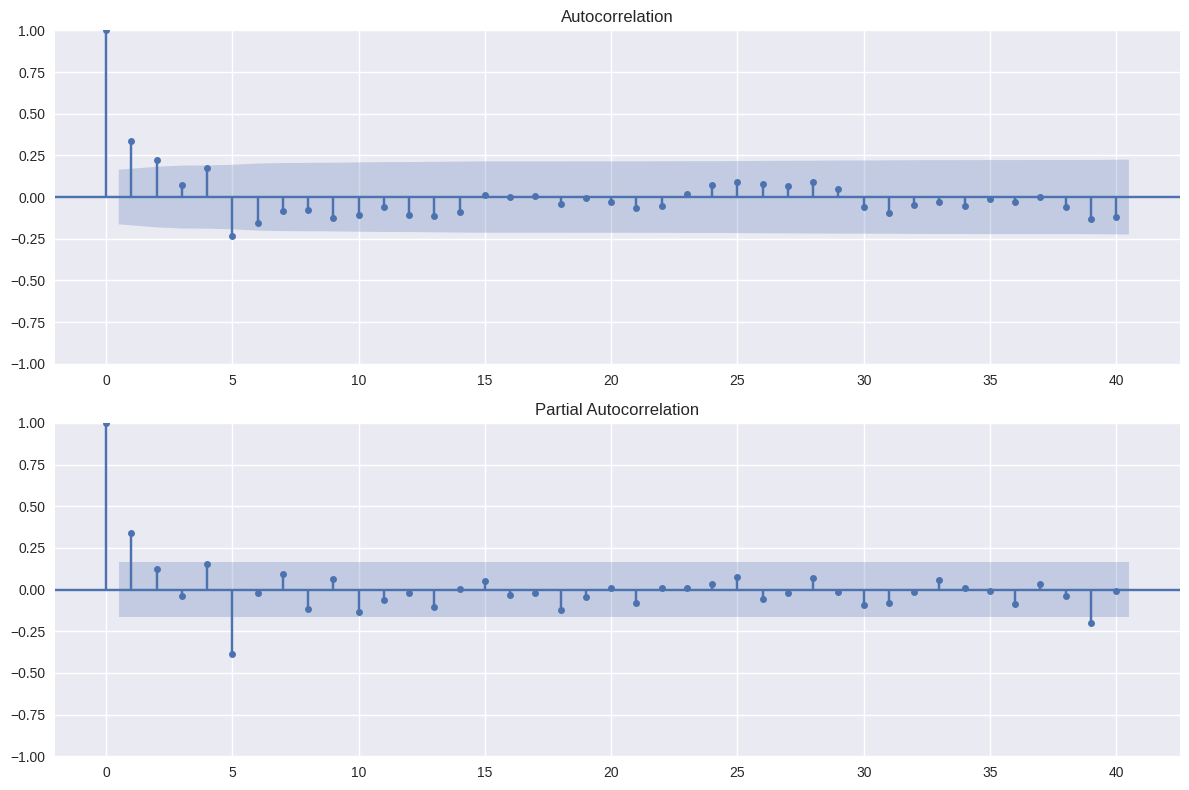

In [91]:
# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(weekly_data['Weekly_Sales'].dropna(), lags=40, ax=ax1)
plot_pacf(weekly_data['Weekly_Sales'].dropna(), lags=40, ax=ax2)
plt.tight_layout()
plt.show()

In [92]:
# Create lag features for the time series
def create_lag_features(df, lags):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df['Weekly_Sales'].shift(lag)
    return df

In [93]:
# Create rolling statistics
def create_rolling_features(df, windows):
    df = df.copy()
    for window in windows:
        df[f'rolling_mean_{window}'] = df['Weekly_Sales'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['Weekly_Sales'].rolling(window=window).std()
    return df

In [94]:
# Apply feature engineering
lags = [1, 2, 3, 4, 5, 13, 26, 52]  # 1 week to 1 year lags
windows = [4, 13, 26, 52]  # 1 month to 1 year windows

weekly_data = create_lag_features(weekly_data, lags)
weekly_data = create_rolling_features(weekly_data, windows)

In [95]:
# Add seasonal features
weekly_data['month'] = weekly_data.index.month
weekly_data['week_of_year'] = weekly_data.index.isocalendar().week

In [96]:
# Drop rows with NaN values created by lag/rolling features
weekly_data = weekly_data.dropna()

In [97]:
print("Final feature set columns:")
print(weekly_data.columns.tolist())

Final feature set columns:
['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_13', 'lag_26', 'lag_52', 'rolling_mean_4', 'rolling_std_4', 'rolling_mean_13', 'rolling_std_13', 'rolling_mean_26', 'rolling_std_26', 'rolling_mean_52', 'rolling_std_52', 'month', 'week_of_year']


Modeling with Traditional Regression Approaches

In [98]:
# Prepare data for modeling
X = weekly_data.drop('Weekly_Sales', axis=1)
y = weekly_data['Weekly_Sales']

In [99]:
# Split data into train and test sets (time-based split)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (72, 22)
Test set size: (19, 22)


In [100]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [101]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [102]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Store results
    results[name] = {
        'model': model,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'predictions': y_pred
    }

    print(f"{name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print()

Linear Regression:
  MSE: 0.00
  MAE: 0.00
  RMSE: 0.00

Ridge Regression:
  MSE: 3987796371851.28
  MAE: 1787136.41
  RMSE: 1996946.76

Lasso Regression:
  MSE: 14014583482.52
  MAE: 101548.40
  RMSE: 118383.21

Random Forest:
  MSE: 1640879983922.60
  MAE: 975190.50
  RMSE: 1280968.38



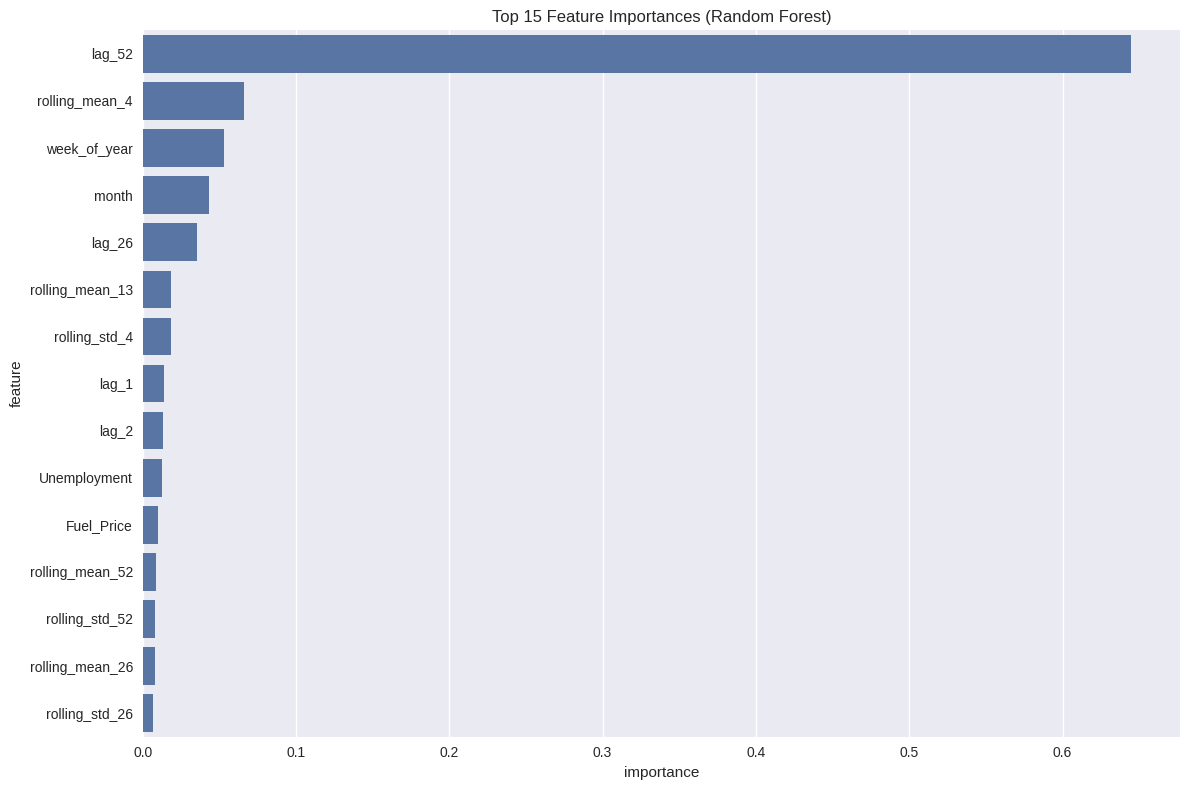

In [103]:
# Plot feature importance for Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

 XGBoost with Time-Aware Validation

In [104]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [105]:
# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'seed': 42
}

In [106]:
# Train the model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

In [107]:
# Make predictions
xgb_pred = xgb_model.predict(dtest)

In [108]:
# Calculate metrics
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)

print("XGBoost Results:")
print(f"  MSE: {xgb_mse:.2f}")
print(f"  MAE: {xgb_mae:.2f}")
print(f"  RMSE: {xgb_rmse:.2f}")

XGBoost Results:
  MSE: 1840675938159.29
  MAE: 956122.51
  RMSE: 1356715.13


In [109]:
# Add to results dictionary
results['XGBoost'] = {
    'model': xgb_model,
    'mse': xgb_mse,
    'mae': xgb_mae,
    'rmse': xgb_rmse,
    'predictions': xgb_pred
}

<Figure size 1200x800 with 0 Axes>

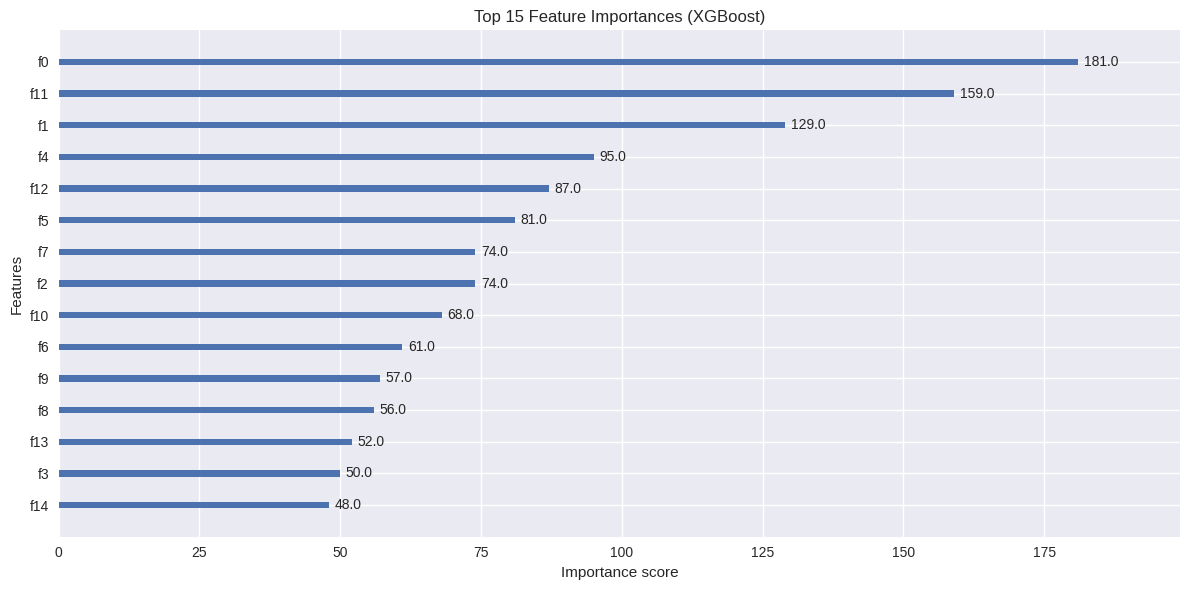

In [110]:
# Plot feature importance for XGBoost
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [111]:
# Time series cross-validation with XGBoost
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []



In [112]:
for train_idx, val_idx in tscv.split(X_train_scaled):
    # Split data
    X_train_cv, X_val_cv = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

In [113]:
    # Create DMatrix
    dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv)
    dval_cv = xgb.DMatrix(X_val_cv, label=y_val_cv)

    # Train model
    model_cv = xgb.train(params, dtrain_cv, num_rounds)

    # Make predictions and calculate RMSE
    pred_cv = model_cv.predict(dval_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_val_cv, pred_cv))
    cv_scores.append(rmse_cv)

print(f"Time Series Cross-Validation RMSE scores: {cv_scores}")
print(f"Average CV RMSE: {np.mean(cv_scores):.2f} (±{np.std(cv_scores):.2f})")

Time Series Cross-Validation RMSE scores: [np.float64(2198706.083109572)]
Average CV RMSE: 2198706.08 (±0.00)


 Results Visualization

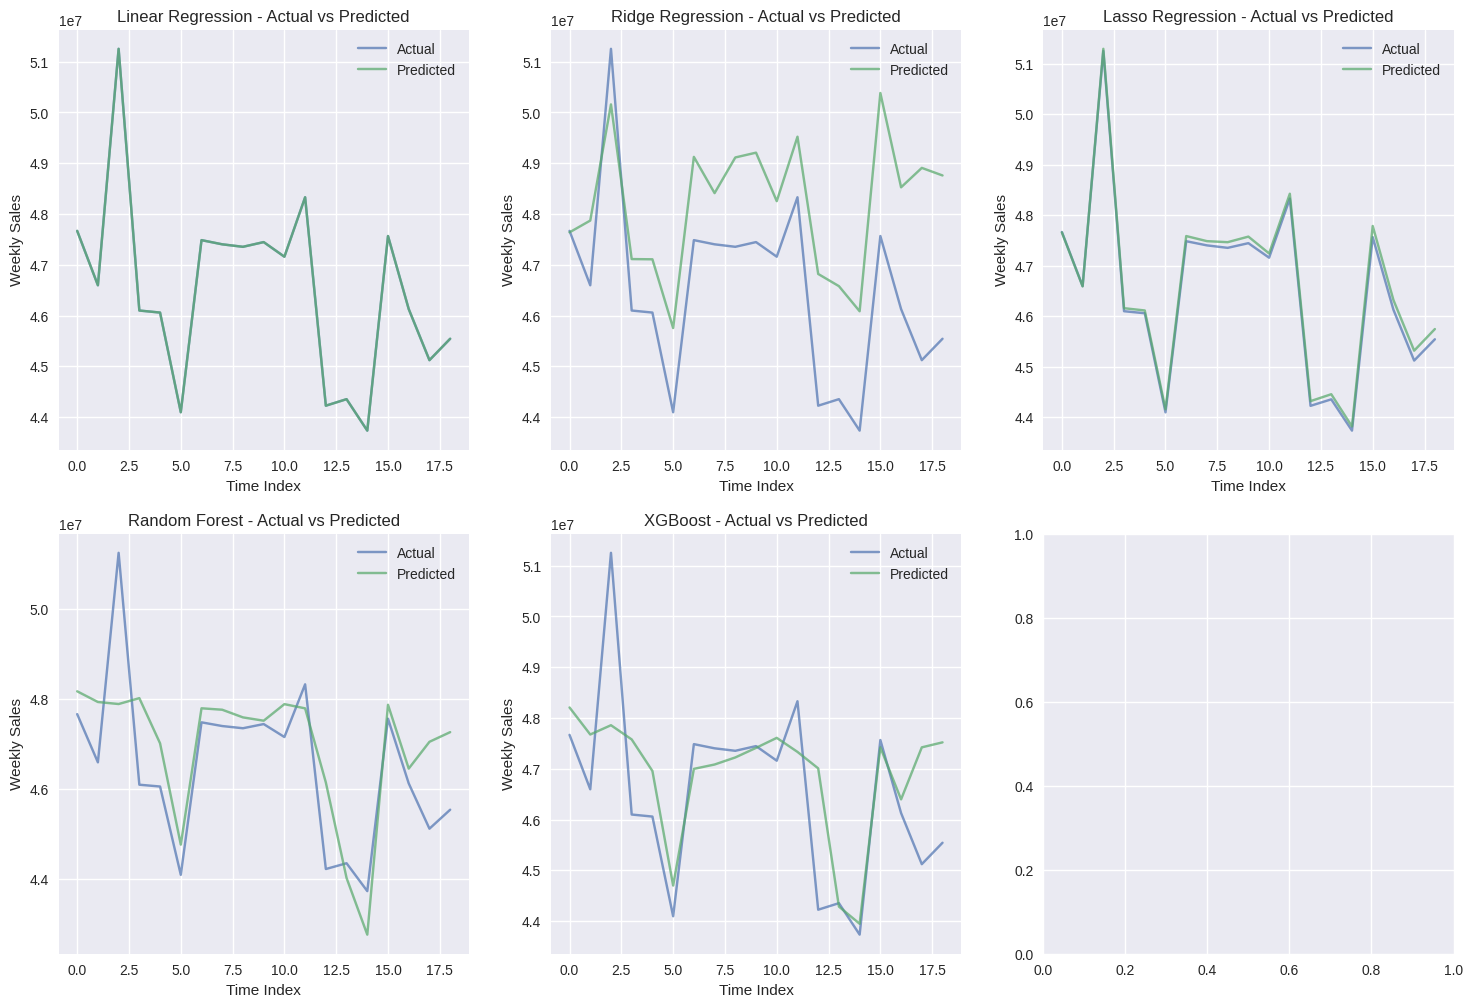

In [114]:
# Plot actual vs predicted values for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

model_names = list(results.keys())
for i, name in enumerate(model_names):
    if name in results:
        y_pred = results[name]['predictions']
        axes[i].plot(y_test.values, label='Actual', alpha=0.7)
        axes[i].plot(y_pred, label='Predicted', alpha=0.7)
        axes[i].set_title(f'{name} - Actual vs Predicted')
        axes[i].set_xlabel('Time Index')
        axes[i].set_ylabel('Weekly Sales')
        axes[i].legend()
        axes[i].grid(True)

In [115]:
# Remove any empty subplots
if len(model_names) < 6:
    for i in range(len(model_names), 6):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

Comparison

In [116]:
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[name]['mse'] for name in results.keys()],
    'MAE': [results[name]['mae'] for name in results.keys()],
    'RMSE': [results[name]['rmse'] for name in results.keys()]
}).sort_values('RMSE')

print("Model Performance Comparison:")
print(model_comparison)

Model Performance Comparison:
               Model           MSE           MAE          RMSE
0  Linear Regression  2.717125e-16  1.450903e-08  1.648370e-08
2   Lasso Regression  1.401458e+10  1.015484e+05  1.183832e+05
3      Random Forest  1.640880e+12  9.751905e+05  1.280968e+06
4            XGBoost  1.840676e+12  9.561225e+05  1.356715e+06
1   Ridge Regression  3.987796e+12  1.787136e+06  1.996947e+06


/tmp/ipython-input-2229849740.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=model_comparison, palette='viridis')


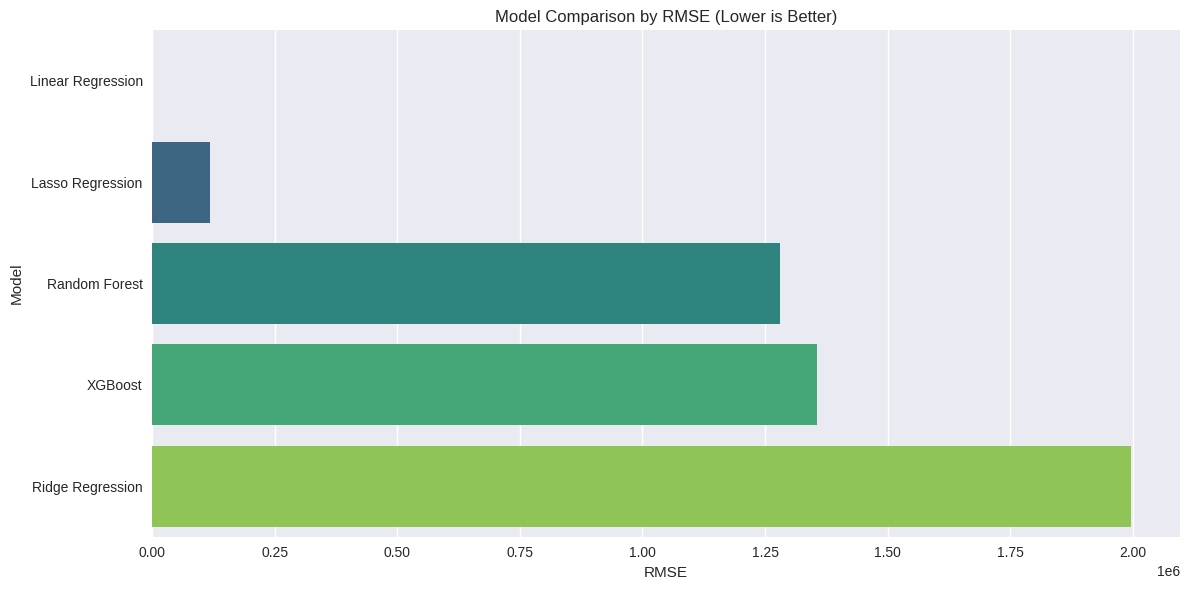

In [117]:
# Plot model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='RMSE', y='Model', data=model_comparison, palette='viridis')
plt.title('Model Comparison by RMSE (Lower is Better)')
plt.xlabel('RMSE')
plt.tight_layout()
plt.show()

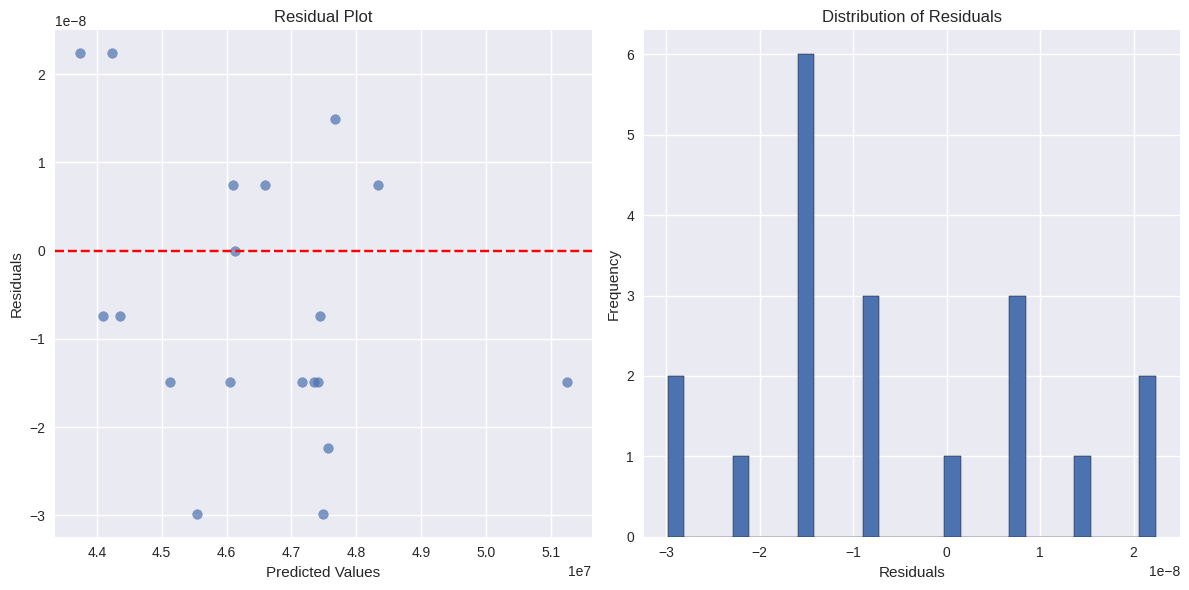

In [118]:
# Plot residuals for the best model
best_model_name = model_comparison.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']

residuals = y_test - best_predictions

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(best_predictions, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

Forecast Future Values

In [122]:
def forecast_future(model, last_known_data, scaler, periods=12):
    """
    Forecast future values using the trained model
    """
    future_predictions = []
    current_data = last_known_data.copy()

    for i in range(periods):
        # Prepare features for prediction
        features = current_data.drop('Weekly_Sales', axis=1, errors='ignore')  # avoid KeyError
        features_scaled = scaler.transform(features.values.reshape(1, -1))

        # Make prediction (using appropriate method based on model type)
        if hasattr(model, 'predict'):
            # Scikit-learn models
            pred = model.predict(features_scaled)[0]
        else:
            # XGBoost model
            dmatrix = xgb.DMatrix(features_scaled)
            pred = model.predict(dmatrix)[0]

        future_predictions.append(pred)

        # Update the current_data for next prediction
        # Shift lag features (only if they exist in current_data)
        for lag in lags:
            lag_col = f'lag_{lag}'
            if lag_col in current_data.columns:
                if lag == 1:
                    current_data[lag_col] = pred
                else:
                    prev_lag = f'lag_{lag-1}'
                    if prev_lag in current_data.columns:
                        current_data[lag_col] = current_data[prev_lag]

        # Update rolling features (simplified approach)
        for window in windows:
            roll_col = f'rolling_mean_{window}'
            if roll_col in current_data.columns:
                # For simplicity, keep the rolling mean same as last value
                # (In real application, maintain a list of predictions to compute rolling)
                current_data[roll_col] = current_data[roll_col]

    return future_predictions


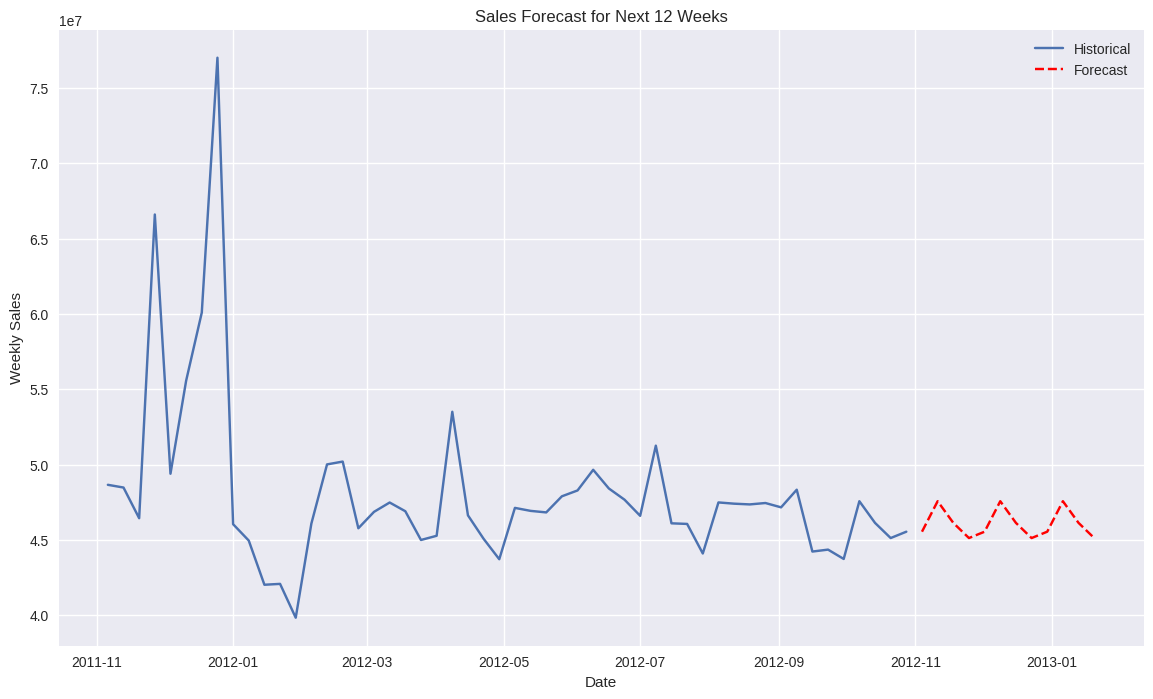

In [123]:
# Plot historical data and forecast
plt.figure(figsize=(14, 8))
plt.plot(weekly_data.index[-52:], weekly_data['Weekly_Sales'].values[-52:], label='Historical')
plt.plot(future_dates, future_sales, label='Forecast', color='red', linestyle='--')
plt.title('Sales Forecast for Next 12 Weeks')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

In [124]:
print("Forecasted sales for the next 12 weeks:")
for i, (date, sales) in enumerate(zip(future_dates, future_sales)):
    print(f"Week {i+1} ({date.strftime('%Y-%m-%d')}): ${sales:,.2f}")

Forecasted sales for the next 12 weeks:
Week 1 (2012-11-04): $45,544,116.29
Week 2 (2012-11-11): $47,566,639.31
Week 3 (2012-11-18): $46,128,514.25
Week 4 (2012-11-25): $45,122,410.57
Week 5 (2012-12-02): $45,544,116.29
Week 6 (2012-12-09): $47,566,639.31
Week 7 (2012-12-16): $46,128,514.25
Week 8 (2012-12-23): $45,122,410.57
Week 9 (2012-12-30): $45,544,116.29
Week 10 (2013-01-06): $47,566,639.31
Week 11 (2013-01-13): $46,128,514.25
Week 12 (2013-01-20): $45,122,410.57
